##INTRODUCTION

In this notebook, two models which are PC and Causal RL are analysed using all datasets (both synthetic csuite ones and the real sachs one). Hartemink discretization is also applied to all datasets and experiment w/ and w/out discreatization. Moreover, performance comparision is made to see the effect of hyperparameter tuning for the RL model.

The PC algorithm (named after its inventors Peter and Clark) is a constraint-based causal discovery algorithm that uses conditional independence tests.

It can be summarised into 2 main steps:

*   It starts with a fully connected graph and then uses conditional independence tests to remove edges and identify the undirected causal graph (nodes linked but with no direction).
*   It then (partially) directs the edges using various orientation tricks.

Second algortihm which is causal discovery for RL is proposed to search for the DAG with the optimal score. The reward is designed to incorporate a predefined score function and two penalty terms to enforce acyclicity. The actor-critic algorithm is used as the RL algorithm, where the actor is constructed based on recently developed encoder-decoder models

The encoder-decoder model takes observable data as input and generates graph adjacency matrices that are used to compute rewards. The reward incorporates both the predefined score function and two penalty terms for enforcing
acyclicity. In contrast with typical RL applications where the goal is to learn a policy, RL is used as a search strategy and our final output would be the graph, among all graphs generated during training, that achieves the best reward.

In [1]:
!git clone https://github.com/diaconuccalin/AI_in_Industry_Project.git

Cloning into 'AI_in_Industry_Project'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 79 (delta 21), reused 74 (delta 17), pack-reused 0
Receiving objects: 100% (79/79), 825.27 KiB | 13.99 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [6]:
!python -m pip install -r /content/AI_in_Industry_Project/requirements.txt

  Using cached alembic-1.13.1-py3-none-any.whl (233 kB)
  Using cached aniso8601-9.0.1-py2.py3-none-any.whl (52 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 3.7 MB/s eta 0:00:00
  Using cached azure_common-1.1.28-py2.py3-none-any.whl (14 kB)
  Using cached azure_core-1.30.1-py3-none-any.whl (193 kB)
  Using cached azure_identity-1.16.0-py3-none-any.whl (166 kB)
  Using cached azure_mgmt_core-1.4.0-py3-none-any.whl (27 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.2/392.2 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.1 MB/s eta 0:00:00
  Using cached causalgen-0.1.1-py3-none-any.whl (12 kB)
  Using cached causica-0.4.0-py3-none-any.whl (111 kB)
  Using cached docker-7.0.0-py3-none-any.whl (147 kB)
  Using cached gcastle-1.0.3-py3-none-any.whl (214 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl (207 kB)
  Using cached graphene-3.3-py2.py3-none-any.whl (128 kB)
  U

In [50]:
import sys
sys.path.append('/content/AI_in_Industry_Project/')

In [55]:
import os
os.chdir('/content/AI_in_Industry_Project/')

In [120]:
import torch
import pandas as pd
import numpy as np
from data.csuite.csuite_datasets import *
from data.sachs.sachs_datasets import unaltered_dataset
from models.causal_rl import causal_rl, train_evaluate_model
from models.pc import pc
from sklearn.model_selection import ParameterGrid
from collections import Counter
import sklearn.feature_selection
import matplotlib.pyplot as plt

In [10]:
 def create_dataset_csuit(method, num_sample):

  df, gt_adj_graph = method(
      num_sample,
      generate_data=True,
      return_adjacency_graph=True
  )
  return df, gt_adj_graph

##Create Datasets

###Csuit

In [67]:
datasets = [lingauss, linexp, nonlingauss, nonlin_simpson, symprod_simpson, large_backdoor, weak_arrows]
data_dict_csuit = {}
for i in datasets:
  data_dict_csuit[i.__name__] = create_dataset(i, 2000)

###Csuit with Hartmenink Discretization

In [68]:
data_dict_csuit_hartemink = {}
for i in datasets:
  df, gt = data_dict_csuit[i.__name__]
  data_dict_csuit_hartemink[i.__name__] = (hartemink_discretization(df), gt)

60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
60
59
58
5

###Sachs

In [77]:
df_sachs ,gt_adj_graph_sachs = unaltered_dataset(return_adjacency_graph=True)

###Sachs with Hartmenink Discretization

In [ ]:
df_sachs_hartemink = hartemink_discretization(df_sachs)

60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4


##PC Model Results for Csuit Datasets

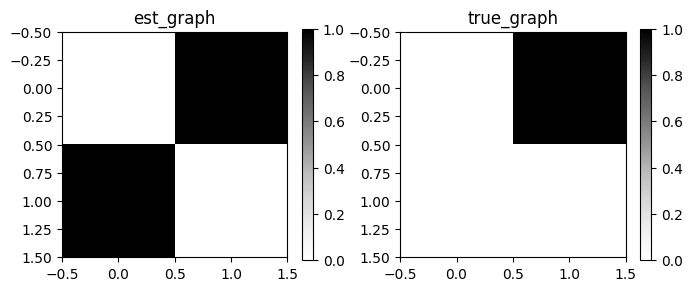

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 1, 'precision': 0.5, 'recall': 1.0, 'F1': 0.6667, 'gscore': 0.0}
lingauss :  {'adjacency_f1': 1.0, 'orientation_f1': 0.0}


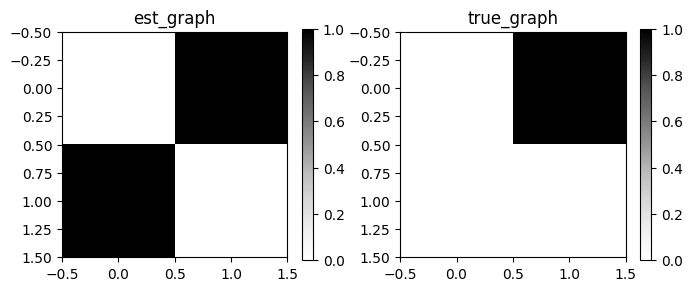

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 1, 'precision': 0.5, 'recall': 1.0, 'F1': 0.6667, 'gscore': 0.0}
linexp :  {'adjacency_f1': 1.0, 'orientation_f1': 0.0}


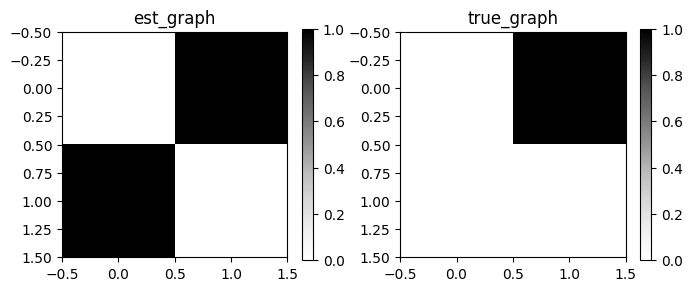

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 1, 'precision': 0.5, 'recall': 1.0, 'F1': 0.6667, 'gscore': 0.0}
nonlingauss :  {'adjacency_f1': 1.0, 'orientation_f1': 0.0}


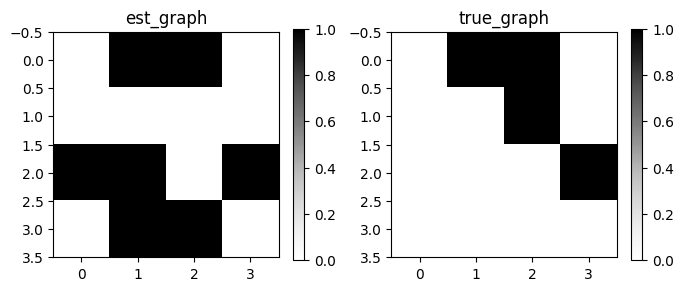

{'fdr': 0.4, 'tpr': 0.75, 'fpr': 1.0, 'shd': 2, 'nnz': 5, 'precision': 0.4286, 'recall': 0.75, 'F1': 0.5455, 'gscore': 0.0}
nonlin_simpson :  {'adjacency_f1': 0.888888888888889, 'orientation_f1': 0.22222222222222224}


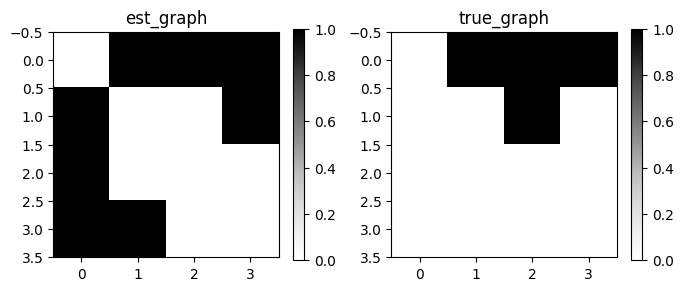

{'fdr': 0.25, 'tpr': 0.75, 'fpr': 0.5, 'shd': 2, 'nnz': 4, 'precision': 0.375, 'recall': 0.75, 'F1': 0.5, 'gscore': 0.0}
symprod_simpson :  {'adjacency_f1': 0.75, 'orientation_f1': 0.0}


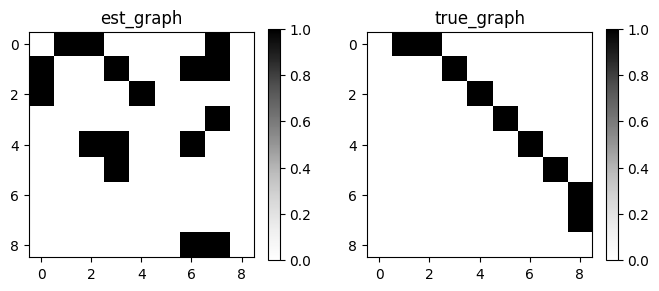

{'fdr': 0.6154, 'tpr': 0.5556, 'fpr': 0.2963, 'shd': 9, 'nnz': 13, 'precision': 0.3125, 'recall': 0.5556, 'F1': 0.4, 'gscore': 0.0}
large_backdoor :  {'adjacency_f1': 0.7272727272727274, 'orientation_f1': 0.18181818181818185}


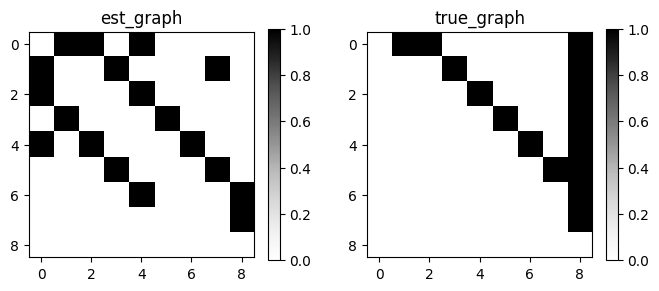

{'fdr': 0.1818, 'tpr': 0.6, 'fpr': 0.0952, 'shd': 8, 'nnz': 11, 'precision': 0.5, 'recall': 0.6, 'F1': 0.5455, 'gscore': 0.0}
weak_arrows :  {'adjacency_f1': 0.6923076923076923, 'orientation_f1': 0.23076923076923075}


In [124]:
metrics_pc_csuit = []

for i in datasets:
  metrics_pc_csuit.append(pc(data_dict_csuit[i.__name__][0], data_dict_csuit[i.__name__][1],i.__name__))

##PC Model Results for Csuit Datasets + Hartemink

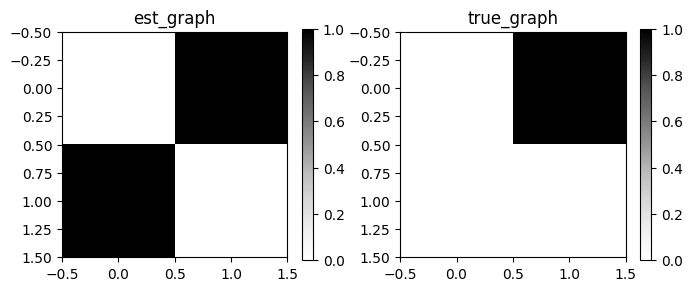

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 1, 'precision': 0.5, 'recall': 1.0, 'F1': 0.6667, 'gscore': 0.0}
lingauss :  {'adjacency_f1': 1.0, 'orientation_f1': 0.0}


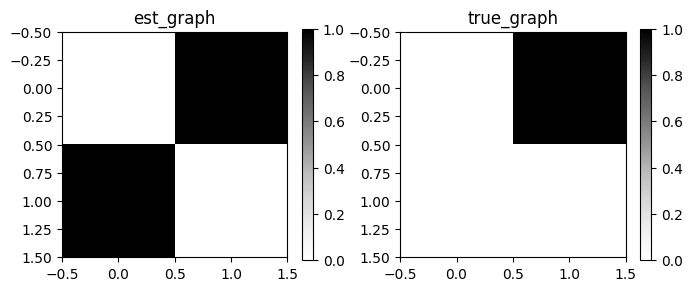

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 1, 'precision': 0.5, 'recall': 1.0, 'F1': 0.6667, 'gscore': 0.0}
linexp :  {'adjacency_f1': 1.0, 'orientation_f1': 0.0}


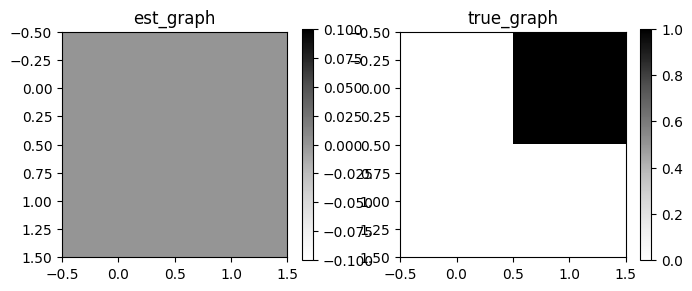

/usr/local/lib/python3.10/dist-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


{'fdr': 0.0, 'tpr': 0.0, 'fpr': 0.0, 'shd': 1, 'nnz': 0, 'precision': nan, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}
nonlingauss :  {'adjacency_f1': 0.0, 'orientation_f1': 0.0}


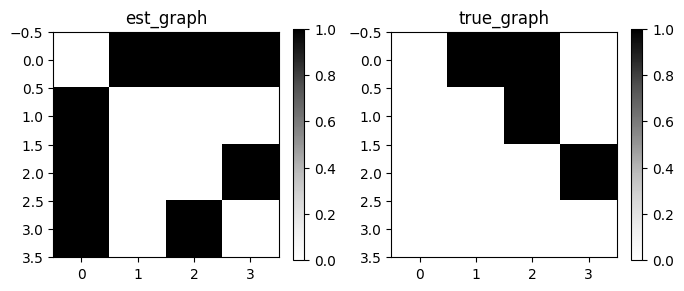

{'fdr': 0.25, 'tpr': 0.75, 'fpr': 0.5, 'shd': 2, 'nnz': 4, 'precision': 0.375, 'recall': 0.75, 'F1': 0.5, 'gscore': 0.0}
nonlin_simpson :  {'adjacency_f1': 0.75, 'orientation_f1': 0.0}


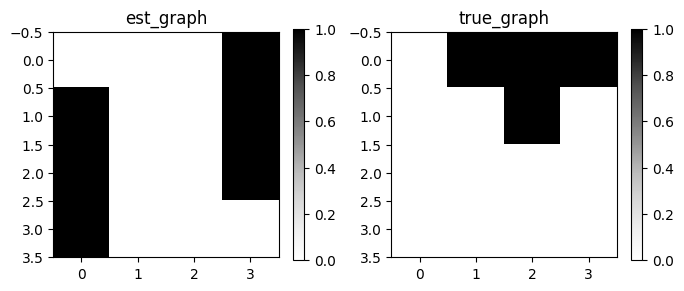

{'fdr': 0.8, 'tpr': 0.25, 'fpr': 2.0, 'shd': 5, 'nnz': 5, 'precision': 0.1667, 'recall': 0.25, 'F1': 0.2, 'gscore': 0.0}
symprod_simpson :  {'adjacency_f1': 0.6666666666666665, 'orientation_f1': 0.0}


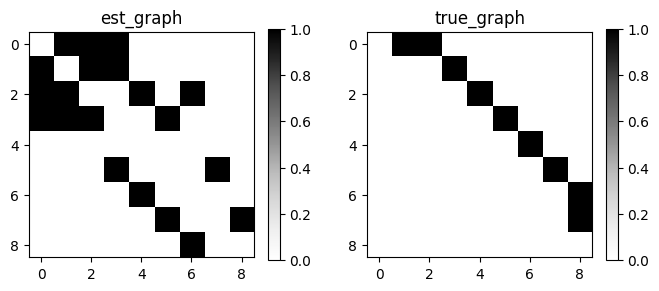

{'fdr': 0.4615, 'tpr': 0.7778, 'fpr': 0.2222, 'shd': 6, 'nnz': 13, 'precision': 0.35, 'recall': 0.7778, 'F1': 0.4828, 'gscore': 0.0}
large_backdoor :  {'adjacency_f1': 0.8181818181818181, 'orientation_f1': 0.18181818181818185}


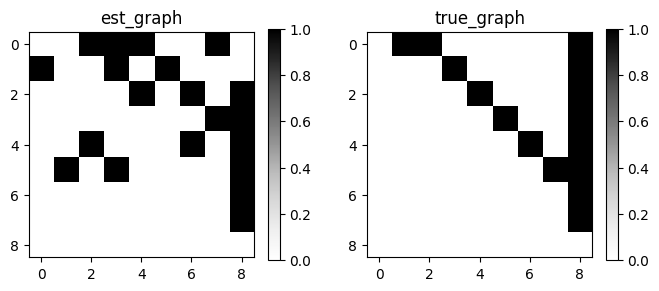

{'fdr': 0.4444, 'tpr': 0.6667, 'fpr': 0.381, 'shd': 11, 'nnz': 18, 'precision': 0.5, 'recall': 0.6667, 'F1': 0.5714, 'gscore': 0.0}
weak_arrows :  {'adjacency_f1': 0.7272727272727272, 'orientation_f1': 0.5454545454545454}


In [126]:
metrics_pc_csuite_hartemink  = []

for i in datasets:
  metrics_pc_csuite_hartemink .append(pc(data_dict_csuit_hartemink[i.__name__][0], data_dict_csuit_hartemink[i.__name__][1],i.__name__))

##PC Model Results for Sachs Dataset

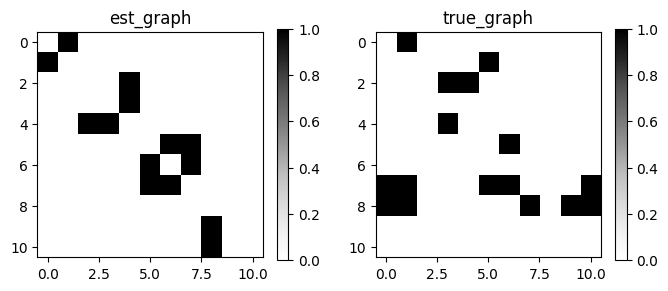

{'fdr': 0.25, 'tpr': 0.375, 'fpr': 0.0513, 'shd': 10, 'nnz': 8, 'precision': 0.4286, 'recall': 0.375, 'F1': 0.4, 'gscore': 0.0}
sachs_dataset :  {'adjacency_f1': 0.6666666666666666, 'orientation_f1': 0.0}


In [128]:
adj_f1_pc_sachs, orient_f1_pc_sachs = pc(df_sachs ,gt_adj_graph_sachs,'sachs_dataset').values()

##PC Model Results for Sachs Dataset + Hartemink

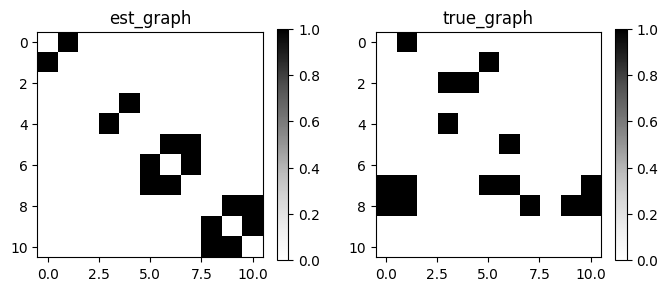

{'fdr': 0.125, 'tpr': 0.4375, 'fpr': 0.0256, 'shd': 10, 'nnz': 8, 'precision': 0.4375, 'recall': 0.4375, 'F1': 0.4375, 'gscore': 0.0}
sachs_dataset_hartemink :  {'adjacency_f1': 0.5833333333333334, 'orientation_f1': 0.0}


In [131]:
adj_f1_pc_sachs_hart, orient_f1_pc_sachs_hart = pc(df_sachs_hartemink, gt_adj_graph_sachs,'sachs_dataset_hartemink').values()

##RL Model Results for Csuit Datasets

100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


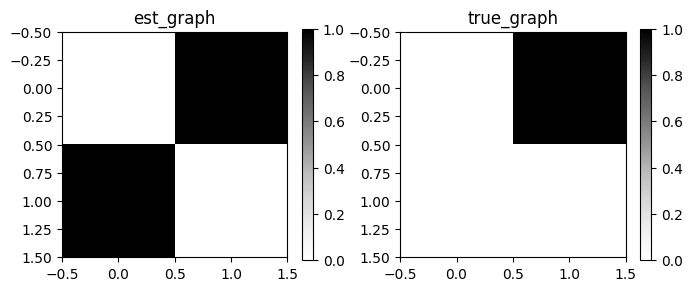

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 1, 'precision': 0.5, 'recall': 1.0, 'F1': 0.6667, 'gscore': 0.0}
lingauss :  {'adjacency_f1': 1.0, 'orientation_f1': 0.0}


100%|██████████| 100/100 [00:09<00:00, 10.12it/s]


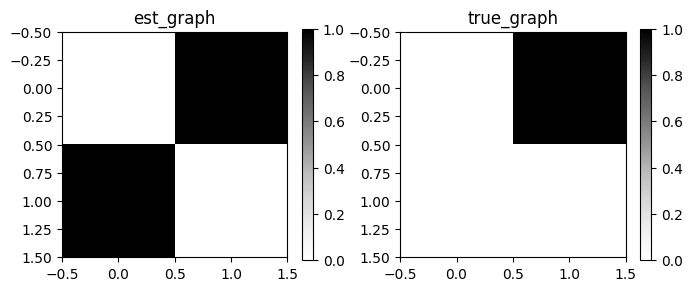

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 1, 'precision': 0.5, 'recall': 1.0, 'F1': 0.6667, 'gscore': 0.0}
linexp :  {'adjacency_f1': 1.0, 'orientation_f1': 0.0}


100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


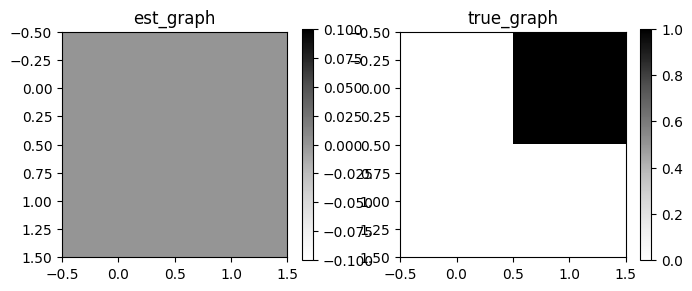

/usr/local/lib/python3.10/dist-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in divide
  precision = TP/TP_FP


{'fdr': 0.0, 'tpr': 0.0, 'fpr': 0.0, 'shd': 1, 'nnz': 0, 'precision': nan, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}
nonlingauss :  {'adjacency_f1': 0.0, 'orientation_f1': 0.0}


100%|██████████| 100/100 [00:12<00:00,  7.96it/s]


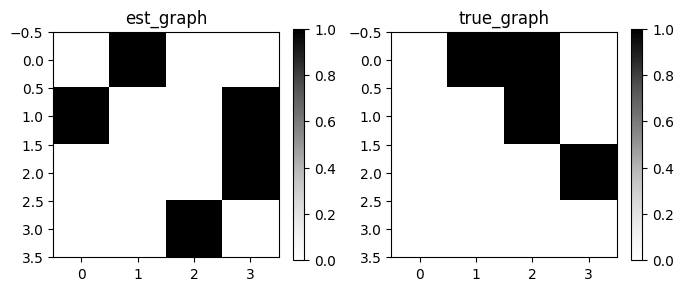

{'fdr': 0.3333, 'tpr': 0.5, 'fpr': 0.5, 'shd': 3, 'nnz': 3, 'precision': 0.4, 'recall': 0.5, 'F1': 0.4444, 'gscore': 0.0}
nonlin_simpson :  {'adjacency_f1': 0.5714285714285715, 'orientation_f1': 0.0}


100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


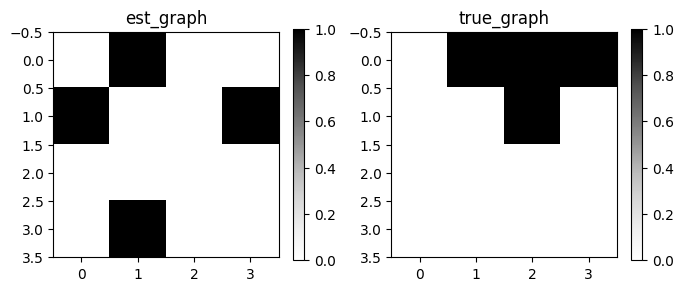

{'fdr': 0.5, 'tpr': 0.25, 'fpr': 0.5, 'shd': 4, 'nnz': 2, 'precision': 0.25, 'recall': 0.25, 'F1': 0.25, 'gscore': 0.0}
symprod_simpson :  {'adjacency_f1': 0.3333333333333333, 'orientation_f1': 0.0}


100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


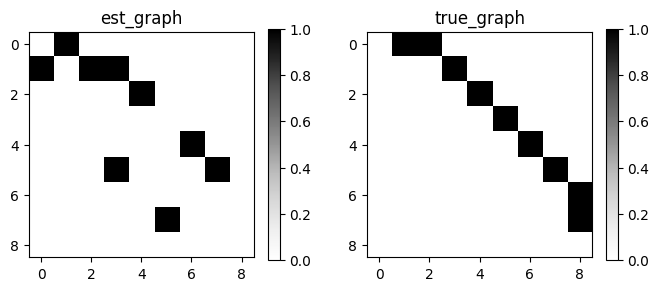

{'fdr': 0.2857, 'tpr': 0.5556, 'fpr': 0.0741, 'shd': 5, 'nnz': 7, 'precision': 0.5556, 'recall': 0.5556, 'F1': 0.5556, 'gscore': 0.1111}
large_backdoor :  {'adjacency_f1': 0.75, 'orientation_f1': 0.375}


100%|██████████| 100/100 [00:34<00:00,  2.90it/s]


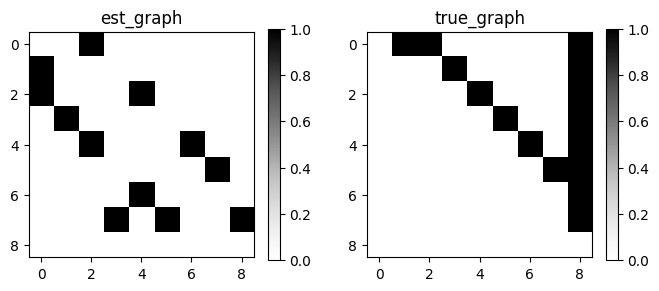

{'fdr': 0.375, 'tpr': 0.3333, 'fpr': 0.1429, 'shd': 11, 'nnz': 8, 'precision': 0.4167, 'recall': 0.3333, 'F1': 0.3704, 'gscore': 0.0}
weak_arrows :  {'adjacency_f1': 0.608695652173913, 'orientation_f1': 0.08695652173913045}


In [115]:
metrics_rl_not_tuned = []

for i in datasets:
  metrics_rl_not_tuned.append(causal_rl(data_dict_csuit[i.__name__][0], data_dict_csuit[i.__name__][1],i.__name__,{'nb_epoch': 100}))

##RL Model Results for Sachs Dataset

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


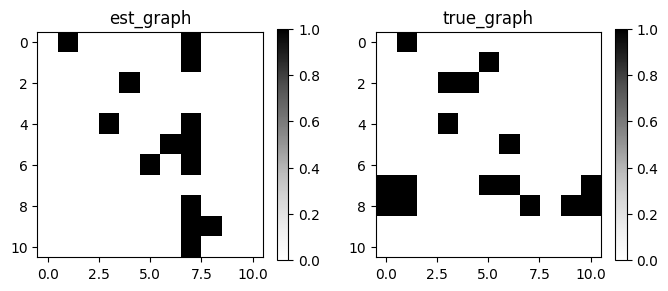

{'fdr': 0.6154, 'tpr': 0.3125, 'fpr': 0.2051, 'shd': 13, 'nnz': 13, 'precision': 0.3571, 'recall': 0.3125, 'F1': 0.3333, 'gscore': 0.0}
sachs_dataset :  {'adjacency_f1': 0.7586206896551724, 'orientation_f1': 0.27586206896551724}


In [116]:
adj_f1_rl_nontuned_sachs, orient_f1_rl_nontuned_sachs = causal_rl(df_sachs ,gt_adj_graph_sachs,'sachs_dataset',{'nb_epoch': 100}).values()

##Hyperparameter-Tuning of RL Model

In [ ]:
param_grid = {   'decoder_hidden_dim':[4,8,16,32],
                 'num_heads':[8,16,32],
                 'num_stacks': [4, 6],
                 'batch_size': [16, 32, 64],
                 'nb_epoch':[100],

    # Add more hyperparameters as needed
}
param_combinations = list(ParameterGrid(param_grid))
# Perform grid search for each dataset using parallel execution
results_rl = {}
for dataset_func in dataset:
  results_rl[str(df, gt_adj_graph, dataset_func)] = {}
  create_dataset(dataset_func, 2000)
    # Generate all possible combinations of hyperparameters
# Print the generated combinations
  for params in param_combinations:
    params_tuple = tuple(params.items())
    results_rl[dataset_name][params_tuple] = train_evaluate_model(RL, df, gt_adj_graph, params)

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


In [ ]:
df_rl = pd.DataFrame(results_rl.values(), index=list(results_rl.keys())).transpose().reset_index(drop=True)

In [ ]:
# Initialize empty dictionaries to store row numbers
max_adjacency_f1_rows = {}
max_orientation_f1_rows = {}
max_adjacency_f1_params = {}
max_orientation_f1_params = {}

# Iterate over each column
for column in df_rl.columns:
    # Initialize variables to store max values and corresponding row numbers
    max_adjacency_f1 = float('-inf')
    max_adjacency_f1_row = None
    max_orientation_f1 = float('-inf')
    max_orientation_f1_row = None

    # Iterate over each row
    for index, row in df_rl.iterrows():
        # Get the dictionary corresponding to the current cell
        cell_data = row[column]

        # Check if the current cell contains valid data
        if isinstance(cell_data, dict):
            # Update max_adjacency_f1 if necessary
            if 'adjacency_f1' in cell_data and cell_data['adjacency_f1'] > max_adjacency_f1:
                max_adjacency_f1 = cell_data['adjacency_f1']
                max_adjacency_f1_row = index

            # Update max_orientation_f1 if necessary
            if 'orientation_f1' in cell_data and cell_data['orientation_f1'] > max_orientation_f1:
                max_orientation_f1 = cell_data['orientation_f1']
                max_orientation_f1_row = index

    # Store the row numbers in the dictionaries
    max_adjacency_f1_rows[column] = max_adjacency_f1_row
    max_orientation_f1_rows[column] = max_orientation_f1_row

    max_adjacency_f1_params[column] = list(results[column])[max_adjacency_f1_row]
    max_orientation_f1_params[column] = list(results[column])[max_orientation_f1_row]

# Print the dictionaries
print("Max Adjacency F1 Rows:", max_adjacency_f1_rows)
print("Max Orientation F1 Rows:", max_orientation_f1_rows)

print("Max Adjacency F1 Params:", max_adjacency_f1_params)
print("Max Orientation F1 Params:", max_orientation_f1_params)

Max Adjacency F1 Rows: {'lingauss': 0, 'linexp': 0, 'nonlingauss': 0, 'nonlin_simpson': 19, 'symprod_simpson': 6, 'large_backdoor': 18, 'weak_arrows': 12}
Max Orientation F1 Rows: {'lingauss': 0, 'linexp': 0, 'nonlingauss': 0, 'nonlin_simpson': 19, 'symprod_simpson': 6, 'large_backdoor': 18, 'weak_arrows': 0}
Max Adjacency F1 Params: {'lingauss': (('batch_size', 16), ('decoder_hidden_dim', 4), ('nb_epoch', 100), ('num_heads', 8), ('num_stacks', 4)), 'linexp': (('batch_size', 16), ('decoder_hidden_dim', 4), ('nb_epoch', 100), ('num_heads', 8), ('num_stacks', 4)), 'nonlingauss': (('batch_size', 16), ('decoder_hidden_dim', 4), ('nb_epoch', 100), ('num_heads', 8), ('num_stacks', 4)), 'nonlin_simpson': (('batch_size', 16), ('decoder_hidden_dim', 32), ('nb_epoch', 100), ('num_heads', 8), ('num_stacks', 6)), 'symprod_simpson': (('batch_size', 16), ('decoder_hidden_dim', 8), ('nb_epoch', 100), ('num_heads', 8), ('num_stacks', 4)), 'large_backdoor': (('batch_size', 16), ('decoder_hidden_dim', 3

In [ ]:
# Initialize empty dictionaries to store row numbers
means = {}
indice_dict = {}
# Iterate over each column
for column in df.columns:
    # Initialize variables to store max values and corresponding row numbers
    # Iterate over each row
    for index, row in df.iterrows():
        # Get the dictionary corresponding to the current cell
        cell_data = row[column]
        mean_metric = (cell_data['adjacency_f1'] + cell_data['orientation_f1'])/2
        if index == 0:
          means[column] = [mean_metric]
        else:
          means[column].append(mean_metric)

for key,values in means.items():
  m = max(values)
  indices = [i for i, j in enumerate(values) if j == m]
  indice_dict[key] = indices

flat_list = [item for sublist in indice_dict.values() for item in sublist]

# Count occurrences of each number
counted = Counter(flat_list)

# Find the most common numbers
most_common_numbers = [num for num, count in counted.items() if count == max(counted.values())]
keys_without_common_numbers = [(key, lst) for key, lst in indice_dict.items() if not any(num in lst for num in most_common_numbers)]

print("Most common numbers:", most_common_numbers)
print("Keys and corresponding lists without common numbers:")
for key, lst in keys_without_common_numbers:
    print(key, ":", lst)

Most common numbers: [18, 20, 22]
Keys and corresponding lists without common numbers:
nonlin_simpson : [19, 21, 23]


In [ ]:
indices = keys_without_common_numbers[0][1] + most_common_numbers
selected_dicts = [param_combinations[i] for i in indices]

# Create DataFrame
df_best_params_rl = pd.DataFrame(selected_dicts).transpose()
df_best_params_rl.columns = indices
df_best_params_rl

,1,3,5,7,9,11,13,15,0,2,4,6,8,10,12,14
alpha,0.950,0.95,0.950,0.95,0.990,0.99,0.990,0.99,0.950,0.95,0.950,0.95,0.990,0.99,0.990,0.99
batch_size,16.000,16.00,16.000,16.00,16.000,16.00,16.000,16.00,16.000,16.00,16.000,16.00,16.000,16.00,16.000,16.00
decoder_hidden_dim,32.000,32.00,32.000,32.00,32.000,32.00,32.000,32.00,32.000,32.00,32.000,32.00,32.000,32.00,32.000,32.00
lr1_decay_step,5000.000,5000.00,10000.000,10000.00,5000.000,5000.00,10000.000,10000.00,5000.000,5000.00,10000.000,10000.00,5000.000,5000.00,10000.000,10000.00
lr1_start,0.001,0.01,0.001,0.01,0.001,0.01,0.001,0.01,0.001,0.01,0.001,0.01,0.001,0.01,0.001,0.01
nb_epoch,100.000,100.00,100.000,100.00,100.000,100.00,100.000,100.00,100.000,100.00,100.000,100.00,100.000,100.00,100.000,100.00
num_heads,8.000,8.00,8.000,8.00,8.000,8.00,8.000,8.00,8.000,8.00,8.000,8.00,8.000,8.00,8.000,8.00
num_stacks,6.000,6.00,6.000,6.00,6.000,6.00,6.000,6.00,4.000,4.00,4.000,4.00,4.000,4.00,4.000,4.00


##RL Tuned Model Results for Csuit Datasets

100%|██████████| 100/100 [00:03<00:00, 26.67it/s]


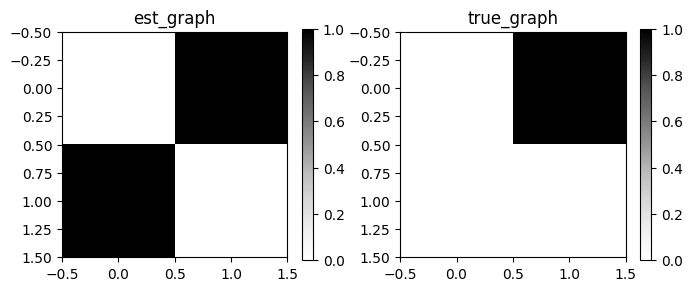

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 1, 'precision': 0.5, 'recall': 1.0, 'F1': 0.6667, 'gscore': 0.0}
lingauss :  {'adjacency_f1': 1.0, 'orientation_f1': 0.0}


100%|██████████| 100/100 [00:02<00:00, 35.84it/s]


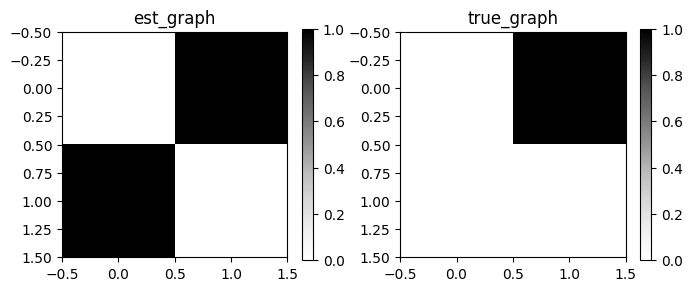

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 1, 'precision': 0.5, 'recall': 1.0, 'F1': 0.6667, 'gscore': 0.0}
linexp :  {'adjacency_f1': 1.0, 'orientation_f1': 0.0}


100%|██████████| 100/100 [00:02<00:00, 35.59it/s]


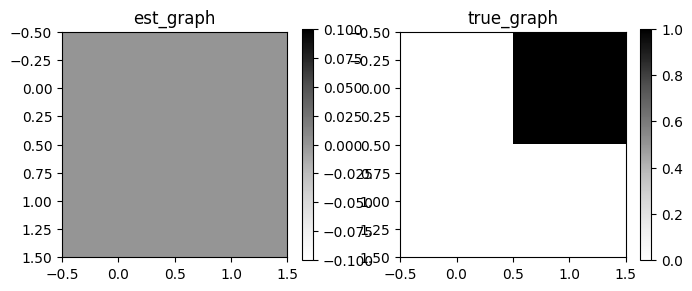

/usr/local/lib/python3.10/dist-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in divide
  precision = TP/TP_FP


{'fdr': 0.0, 'tpr': 0.0, 'fpr': 0.0, 'shd': 1, 'nnz': 0, 'precision': nan, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}
nonlingauss :  {'adjacency_f1': 0.0, 'orientation_f1': 0.0}


100%|██████████| 100/100 [00:06<00:00, 15.62it/s]


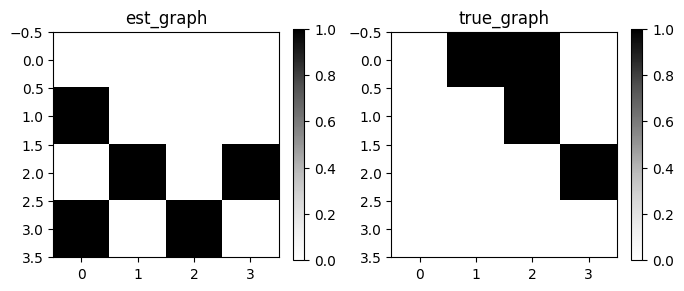

{'fdr': 0.75, 'tpr': 0.25, 'fpr': 1.5, 'shd': 4, 'nnz': 4, 'precision': 0.2, 'recall': 0.25, 'F1': 0.2222, 'gscore': 0.0}
nonlin_simpson :  {'adjacency_f1': 0.75, 'orientation_f1': 0.0}


100%|██████████| 100/100 [00:04<00:00, 21.68it/s]


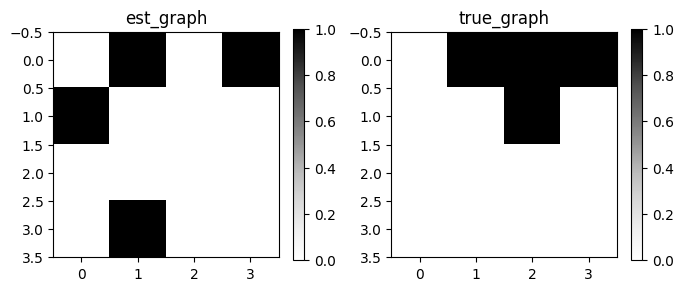

{'fdr': 0.3333, 'tpr': 0.5, 'fpr': 0.5, 'shd': 3, 'nnz': 3, 'precision': 0.5, 'recall': 0.5, 'F1': 0.5, 'gscore': 0.0}
symprod_simpson :  {'adjacency_f1': 0.5714285714285715, 'orientation_f1': 0.28571428571428575}


100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


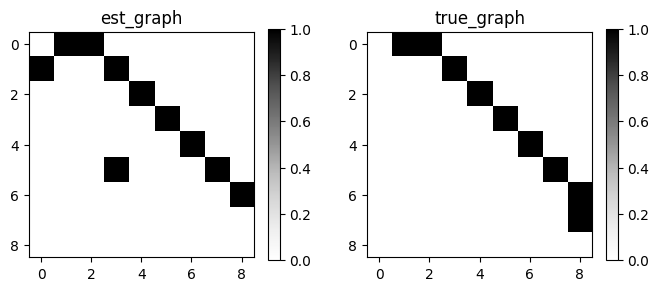

{'fdr': 0.0, 'tpr': 0.8889, 'fpr': 0.0, 'shd': 1, 'nnz': 8, 'precision': 0.8, 'recall': 0.8889, 'F1': 0.8421, 'gscore': 0.6667}
large_backdoor :  {'adjacency_f1': 0.9411764705882353, 'orientation_f1': 0.7058823529411765}


100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


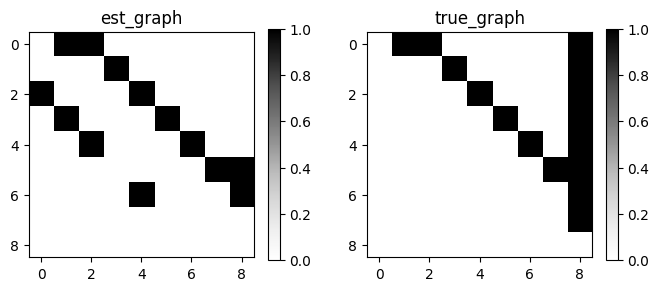

{'fdr': 0.0, 'tpr': 0.6, 'fpr': 0.0, 'shd': 6, 'nnz': 9, 'precision': 0.6923, 'recall': 0.6, 'F1': 0.6429, 'gscore': 0.3333}
weak_arrows :  {'adjacency_f1': 0.7499999999999999, 'orientation_f1': 0.4166666666666667}


In [132]:
param_grid_final = {
    'batch_size': 16,
    'nb_epoch': 100,
    'num_heads': 8,
    'num_stacks': 4,
    'decoder_hidden_dim': 32,
    # Add more hyperparameters as needed
}

metrics_rl_tuned_csuite  = []

for i in datasets:
  metrics_rl_tuned_csuite.append(causal_rl(data_dict_csuit[i.__name__][0], data_dict_csuit[i.__name__][1],i.__name__,param_grid_final))

##RL Tuned Model Results for Csuit Datasets + Hartemink

100%|██████████| 100/100 [00:02<00:00, 35.31it/s]


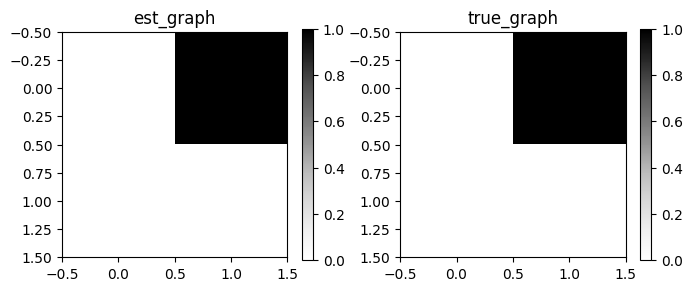

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 1, 'precision': 1.0, 'recall': 1.0, 'F1': 1.0, 'gscore': 1.0}
lingauss :  {'adjacency_f1': 1.0, 'orientation_f1': 1.0}


100%|██████████| 100/100 [00:03<00:00, 32.94it/s]


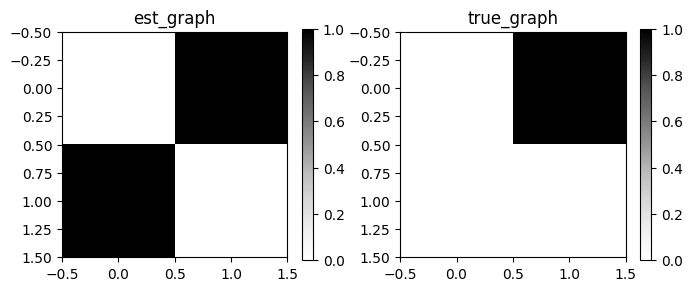

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 1, 'precision': 0.5, 'recall': 1.0, 'F1': 0.6667, 'gscore': 0.0}
linexp :  {'adjacency_f1': 1.0, 'orientation_f1': 0.0}


100%|██████████| 100/100 [00:03<00:00, 28.93it/s]


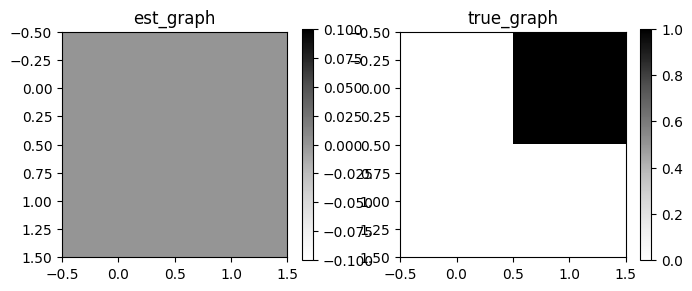

/usr/local/lib/python3.10/dist-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in divide
  precision = TP/TP_FP


{'fdr': 0.0, 'tpr': 0.0, 'fpr': 0.0, 'shd': 1, 'nnz': 0, 'precision': nan, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}
nonlingauss :  {'adjacency_f1': 0.0, 'orientation_f1': 0.0}


100%|██████████| 100/100 [00:04<00:00, 21.65it/s]


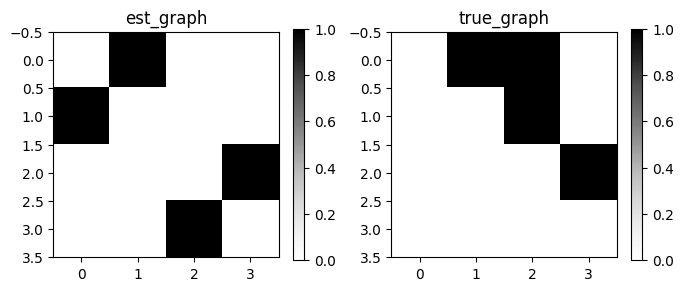

{'fdr': 0.0, 'tpr': 0.5, 'fpr': 0.0, 'shd': 2, 'nnz': 2, 'precision': 0.5, 'recall': 0.5, 'F1': 0.5, 'gscore': 0.0}
nonlin_simpson :  {'adjacency_f1': 0.6666666666666666, 'orientation_f1': 0.0}


100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


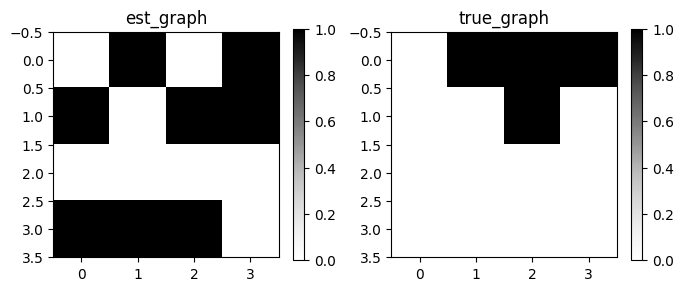

{'fdr': 0.4, 'tpr': 0.75, 'fpr': 1.0, 'shd': 3, 'nnz': 5, 'precision': 0.375, 'recall': 0.75, 'F1': 0.5, 'gscore': 0.0}
symprod_simpson :  {'adjacency_f1': 0.6666666666666665, 'orientation_f1': 0.22222222222222224}


100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


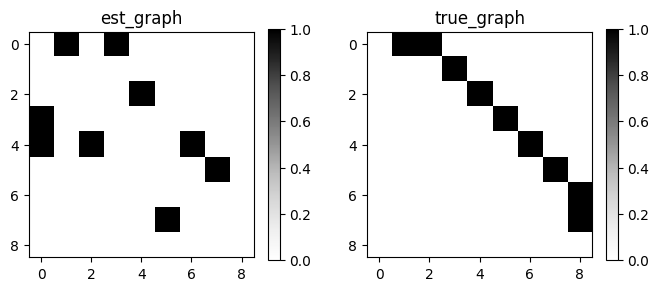

{'fdr': 0.3333, 'tpr': 0.4444, 'fpr': 0.0741, 'shd': 7, 'nnz': 6, 'precision': 0.4444, 'recall': 0.4444, 'F1': 0.4444, 'gscore': 0.0}
large_backdoor :  {'adjacency_f1': 0.5333333333333333, 'orientation_f1': 0.26666666666666666}


100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


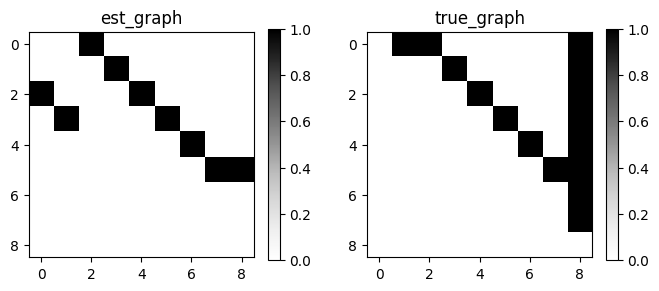

{'fdr': 0.0, 'tpr': 0.4667, 'fpr': 0.0, 'shd': 8, 'nnz': 7, 'precision': 0.7778, 'recall': 0.4667, 'F1': 0.5833, 'gscore': 0.3333}
weak_arrows :  {'adjacency_f1': 0.6363636363636364, 'orientation_f1': 0.4545454545454545}


In [133]:
metrics_rl_tuned_csuite_hartemink  = []

for i in datasets:
  metrics_rl_tuned_csuite_hartemink.append(causal_rl(data_dict_csuit_hartemink[i.__name__][0], data_dict_csuit_hartemink[i.__name__][1],i.__name__,param_grid_final))

##RL Tuned Model Results for Sachs Dataset

100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


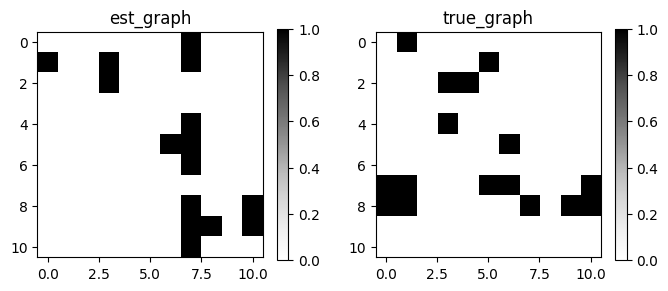

{'fdr': 0.7333, 'tpr': 0.25, 'fpr': 0.2821, 'shd': 16, 'nnz': 15, 'precision': 0.2667, 'recall': 0.25, 'F1': 0.2581, 'gscore': 0.0}
sachs_dataset :  {'adjacency_f1': 0.7096774193548386, 'orientation_f1': 0.2580645161290323}


In [134]:
adj_f1_rl_sachs, orient_f1_rl_sachs = causal_rl(df_sachs ,gt_adj_graph_sachs,'sachs_dataset',param_grid_final).values()

##RL Tuned Model Results for Sachs Dataset + Hartemink

100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


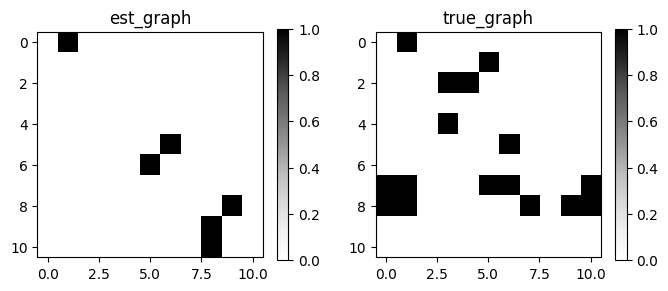

{'fdr': 0.25, 'tpr': 0.1875, 'fpr': 0.0256, 'shd': 13, 'nnz': 4, 'precision': 0.5, 'recall': 0.1875, 'F1': 0.2727, 'gscore': 0.0}
sachs_dataset_hartemink :  {'adjacency_f1': 0.4, 'orientation_f1': 0.1}


In [135]:
adj_f1_rl_sachs_hart, orient_f1_rl_sachs_hart = causal_rl(df_sachs_hartemink, gt_adj_graph_sachs,'sachs_dataset_hartemink',param_grid_final).values()

##PC Performance Comparision on All Datasets with and without Hartemink Discretization

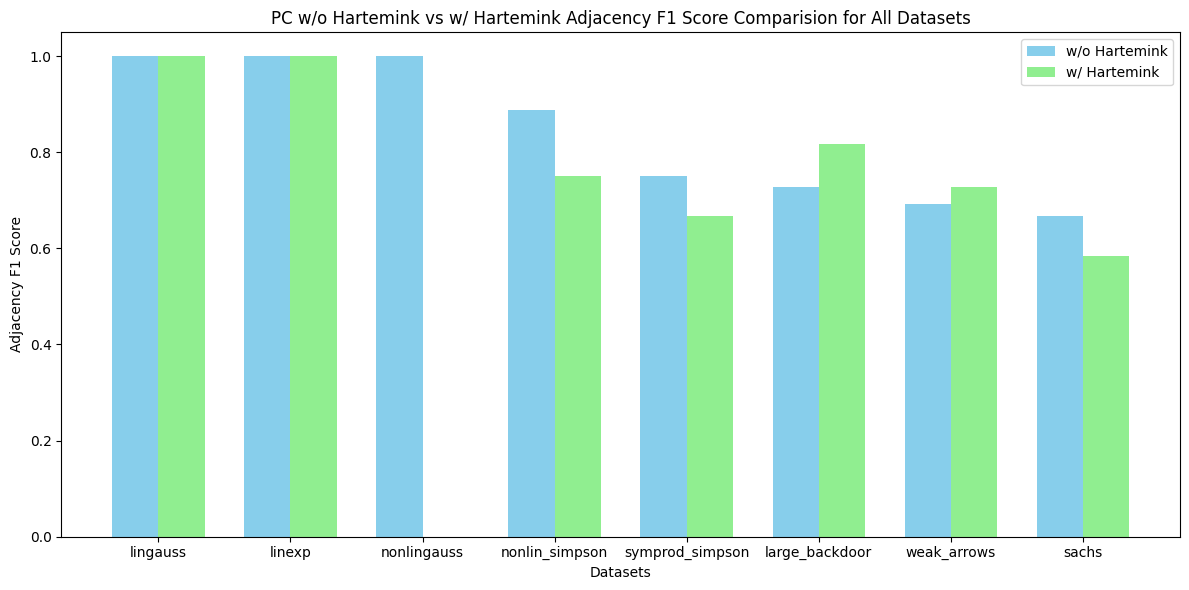

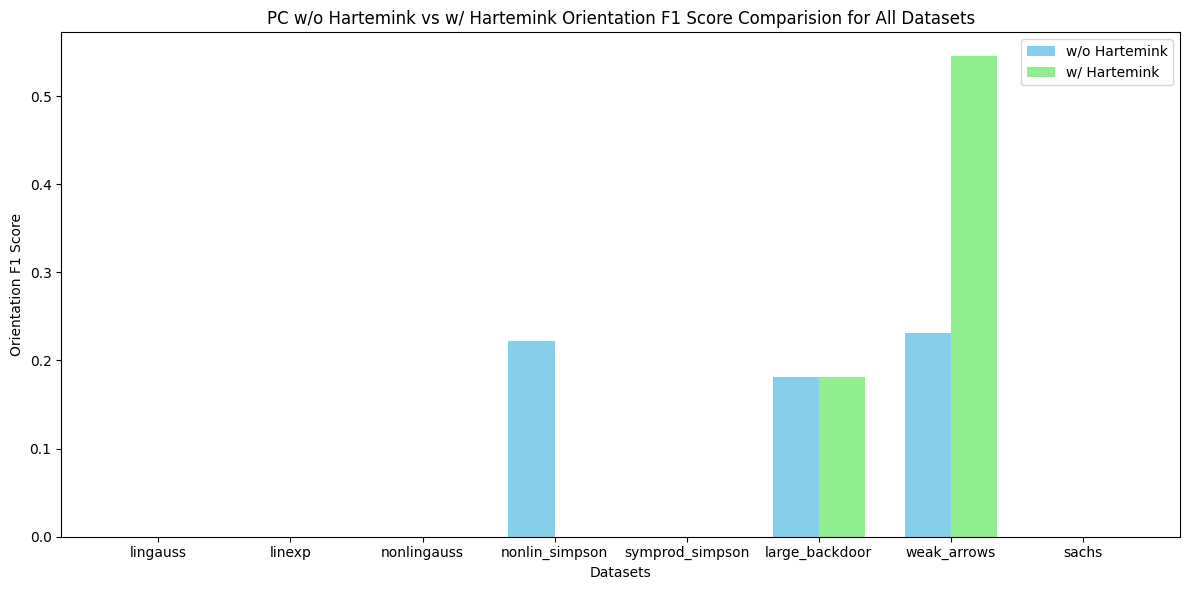

In [137]:
all_datasets = [i.__name__ for i in datasets] + ['sachs']

PC_adjacency = [d['adjacency_f1'] for d in metrics_pc_csuit] + [adj_f1_pc_sachs]
PC_adjacency_hart = [d['adjacency_f1'] for d in metrics_pc_csuite_hartemink] + [adj_f1_pc_sachs_hart]

PC_orientation = [d['orientation_f1'] for d in metrics_pc_csuit] + [orient_f1_pc_sachs]
PC_orientation_hart = [d['orientation_f1'] for d in metrics_pc_csuite_hartemink] + [orient_f1_pc_sachs_hart]

# Define colors
colors = ['skyblue', 'lightgreen']
bar_width = 0.35
index = range(len(all_datasets))

# Plot sequence F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, PC_adjacency, bar_width, label='w/o Hartemink', color=colors[0])
plt.bar([i + bar_width for i in index], PC_adjacency_hart, bar_width, label='w/ Hartemink', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('Adjacency F1 Score')
plt.title('PC w/o Hartemink vs w/ Hartemink Adjacency F1 Score Comparision for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

# Plot unrolled F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, PC_orientation, bar_width, label='w/o Hartemink', color=colors[0])
plt.bar([i + bar_width for i in index], PC_orientation_hart, bar_width, label='w/ Hartemink', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('Orientation F1 Score')
plt.title('PC w/o Hartemink vs w/ Hartemink Orientation F1 Score Comparision for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

##RL Tuned vs Non-Tuned Comparision for All Datasets

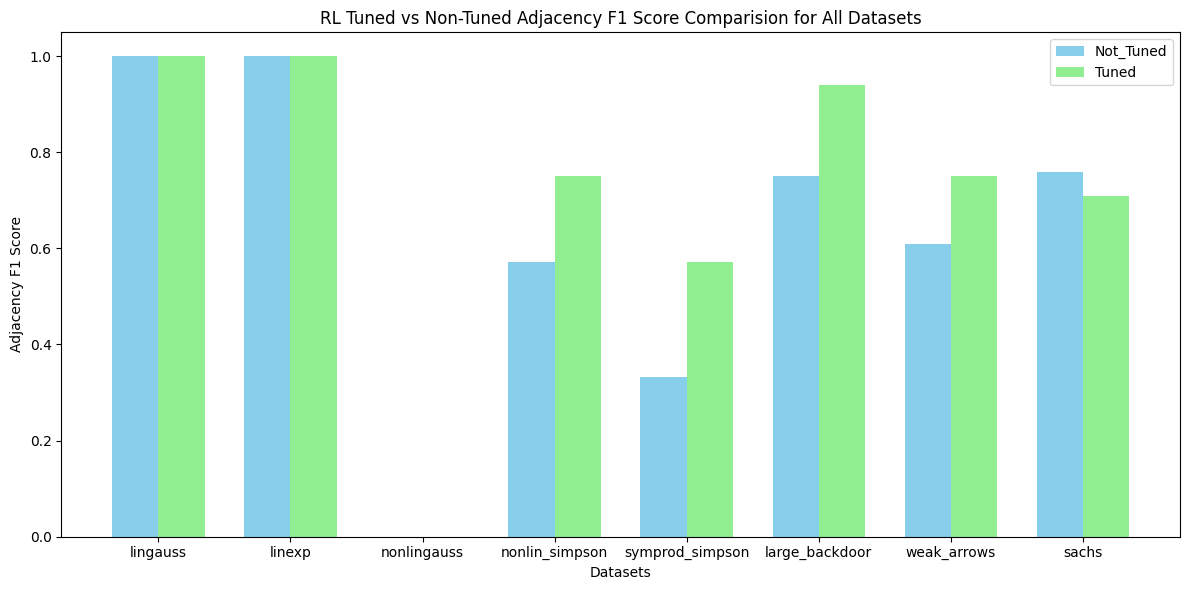

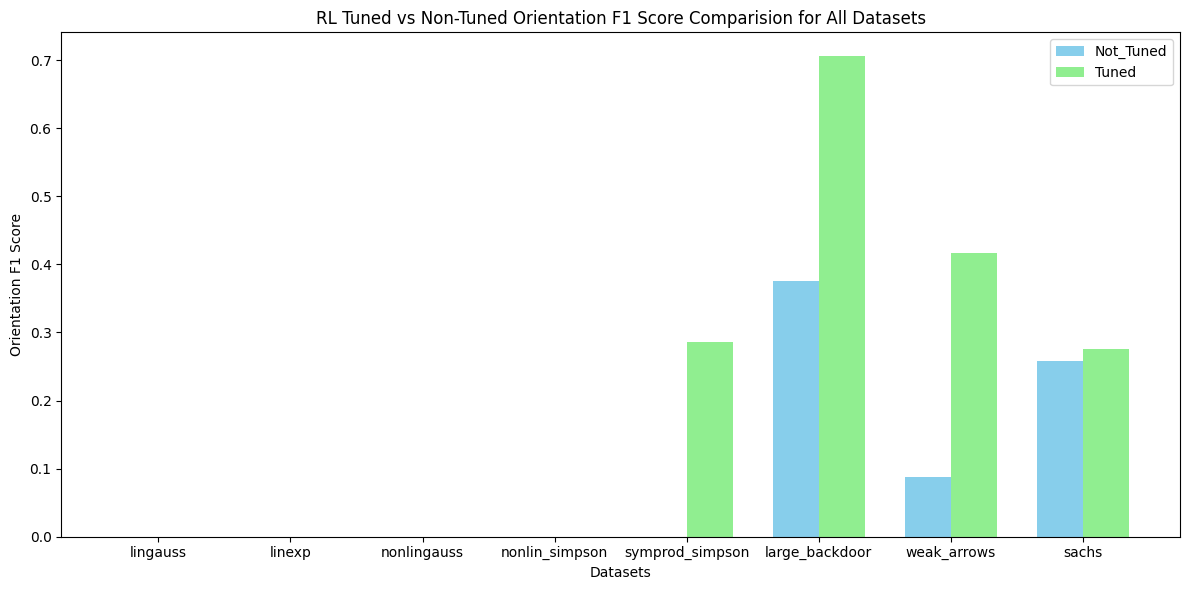

In [111]:
all_datasets = [i.__name__ for i in datasets] + ['sachs']

not_tuned_adjacency = [d['adjacency_f1'] for d in metrics_rl_not_tuned] + [adj_f1_rl_nontuned_sachs]
tuned_adjacency = [d['adjacency_f1'] for d in metrics_rl_tuned_csuite] + [adj_f1_rl_sachs]

not_tuned_orientation = [d['orientation_f1'] for d in metrics_rl_not_tuned] + [orient_f1_rl_sachs]
tuned_orientation = [d['orientation_f1'] for d in metrics_rl_tuned_csuite] + [orient_f1_rl_nontuned_sachs]


# Define colors
colors = ['skyblue', 'lightgreen']
bar_width = 0.35
index = range(len(all_datasets))

# Plot sequence F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, not_tuned_adjacency, bar_width, label='Not_Tuned', color=colors[0])
plt.bar([i + bar_width for i in index], tuned_adjacency, bar_width, label='Tuned', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('Adjacency F1 Score')
plt.title('RL Tuned vs Non-Tuned Adjacency F1 Score Comparision for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

# Plot unrolled F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, not_tuned_orientation, bar_width, label='Not_Tuned', color=colors[0])
plt.bar([i + bar_width for i in index], tuned_orientation, bar_width, label='Tuned', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('Orientation F1 Score')
plt.title('RL Tuned vs Non-Tuned Orientation F1 Score Comparision for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

##RL Tuned Performance Comparision on All Datasets with and without Hartemink Discretization

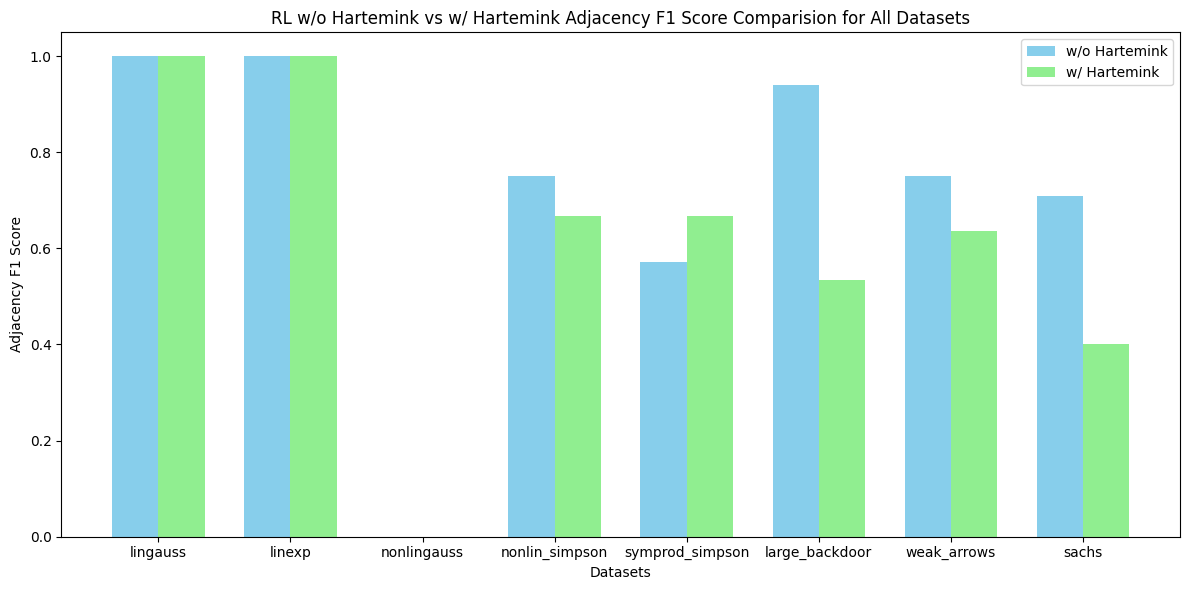

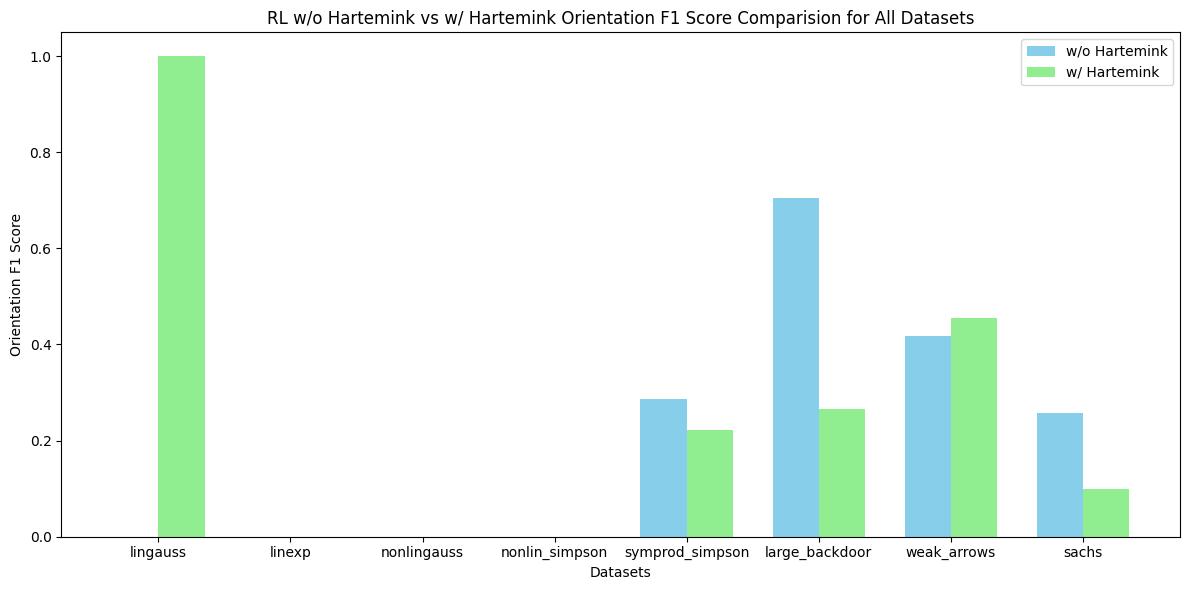

In [101]:
all_datasets = [i.__name__ for i in datasets] + ['sachs']

tuned_adjacency = [d['adjacency_f1'] for d in metrics_rl_tuned_csuite] + [adj_f1_rl_sachs]
tuned_adjacency_hart = [d['adjacency_f1'] for d in metrics_rl_tuned_csuite_hartemink] + [adj_f1_rl_sachs_hart]

tuned_orientation = [d['orientation_f1'] for d in metrics_rl_tuned_csuite] + [orient_f1_rl_sachs]
tuned_orientation_hart = [d['orientation_f1'] for d in metrics_rl_tuned_csuite_hartemink] + [orient_f1_rl_sachs_hart]

# Define colors
colors = ['skyblue', 'lightgreen']
bar_width = 0.35
index = range(len(all_datasets))

# Plot sequence F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, tuned_adjacency, bar_width, label='w/o Hartemink', color=colors[0])
plt.bar([i + bar_width for i in index], tuned_adjacency_hart, bar_width, label='w/ Hartemink', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('Adjacency F1 Score')
plt.title('RL w/o Hartemink vs w/ Hartemink Adjacency F1 Score Comparision for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

# Plot unrolled F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, tuned_orientation, bar_width, label='w/o Hartemink', color=colors[0])
plt.bar([i + bar_width for i in index], tuned_orientation_hart, bar_width, label='w/ Hartemink', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('Orientation F1 Score')
plt.title('RL w/o Hartemink vs w/ Hartemink Orientation F1 Score Comparision for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

##ERROR ANALYSIS

###PC

**lingauss, linexp, nonlingauss:**
These datasets have linear or non-linear relationships with Gaussian or exponential noise. The PC model performs well on these datasets, achieving high TPR and precision with low FDR and FPR. This is because the underlying relationships are relatively simple and can be accurately captured by the PC algorithm.

**nonlin_simpson, symprod_simpson, large_backdoor, weak_arrows:**
These datasets have more complex relationships, including non-linearities, Simpson's paradox, and pyramidal graph structures. The PC model's performance is slightly lower on these datasets compared to the simpler datasets. The FDR is higher, indicating more false discoveries, and the TPR may be slightly lower due to the complexity of the relationships.

**sachs_dataset:**
The Sachs dataset represents real-world molecular concentration data with non-linear and skewed distributions. The PC model's performance on this dataset is moderate, with a relatively high FDR and moderate TPR. This could be due to the complexity and non-linearity of the relationships in the dataset.

**Datasets after Hartemink Discretization:**

Discretization leads to varying effects on these datasets. In some cases, like nonlin_simpson, the performance remains relatively stable, while in others, like symprod_simpson and large_backdoor, there is a slight decrease in performance, particularly in terms of FDR and precision.

Discretization of the Sachs dataset results in a slight improvement in performance, with a decrease in FDR and an increase in precision. This suggests that discretization might help simplify the relationships and improve the model's ability to capture causal relationships in the data.

**Conclusion:**


*   The PC model generally performs well in edge prediction but struggles with edge orientation across datasets.
*   Simpler datasets with linear relationships and Gaussian noise tend to yield better performance. Complex datasets with non-linearities and structural complexities may challenge the PC model, leading to higher FDR and lower precision.
*   Hartemink discretization has mixed effects on model performance, with some datasets showing improvement and others experiencing slight degradation.

###CAUSAL RL

**lingauss, linexp:**
The RL model achieves perfect adjacency F1 score but struggles with orientation (F1 = 0.0) in both cases.
These datasets might have straightforward relationships captured well by adjacency matrices but more complex directional dependencies not effectively captured by the RL model.

**nonlingauss:**
RL model fails to predict any edges (adjacency F1 = 0.0) and struggles with orientation as well.
This dataset may contain non-linear relationships or noise that the RL model cannot effectively learn from.

**nonlin_simpson:**
Moderate performance with decent adjacency F1 score (0.75) but still struggles with orientation (F1 = 0.0).
Complex relationships in this dataset might pose challenges for the RL model's orientation prediction.

**symprod_simpson:**
Achieves decent performance in both adjacency (0.57) and orientation (0.29) F1 scores.
The RL model captures some of the relationships effectively but still struggles with complex orientation.

**large_backdoor:**
Excellent performance with high adjacency (0.94) and orientation (0.71) F1 scores.
The RL model excels in capturing the complex backdoor relationships present in this dataset.

**weak_arrows:**
Achieves decent performance in both adjacency (0.75) and orientation (0.42) F1 scores.
The RL model performs relatively well but still struggles with capturing all weak arrow relationships accurately.

**Data After Hartemink Discretization:**
After discretization, the RL model generally shows improvement in adjacency and orientation F1 scores across most datasets.

**RL Model Strengths:**

*   Effective in capturing complex causal structures such as backdoor paths and weak arrows.
*   Ability to adapt and optimize graph structures based on dataset characteristics.

**PC Model Strengths:**

*   Maintains consistent performance across datasets, especially in capturing certain causal structures.
*   Well-suited for datasets with simpler causal relationships.